In [322]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.interpolate import griddata, RectBivariateSpline
from scipy.optimize import brentq
import warnings
warnings.filterwarnings('ignore')

We are given five different strike prices and five different maturity dates and the corresponding call option prices for a non-dividend stock whose current value is 100 euros. The risk free rate is 5 percent. 

In [385]:
S=80  # Stock price
r=0.05 # Rate of interest 
y=0    # We are considering non-dividend stocks

strikes = np.array([80, 90, 100, 110, 120] * 5)
times = np.repeat([0.25, 0.5, 0.75, 1.0, 1.5], 5)  
market_prices = np.array([ 20.15, 10.52, 3.85, 0.89, 0.11,
                          20.95, 12.10, 5.87, 2.15, 0.58, 
                          21.75, 13.45, 7.55, 3.45, 1.25,
                          22.50, 14.65, 9.05, 4.75, 2.15,
                          24.25, 17.15, 11.85, 7.65, 4.75
                        ])
options=np.array(["call"]*25)

Lets create a dataframe df to store the strikes, maturities, market-prices and option type for the above data.

In [333]:
df=pd.DataFrame({"strike_price":strikes,"maturity":times, "market_price": market_prices, "option_type": options})

In [335]:
df.head()

,strike_price,maturity,market_price,option_type
0,80,0.25,20.15,call
1,90,0.25,10.52,call
2,100,0.25,3.85,call
3,110,0.25,0.89,call
4,120,0.25,0.11,call


We want to predict the option price for any strike price and maturity in this range. This is a common problem in options pricing. To do this we will invert the black-scholes model to derive the corresponding volatilities using the Newton-Rhapson's method. We will then use a interpolating function to calculate the volatility for any strike and maturity.  

Let us first write a function to define the black scholes price. 

In [337]:
def BlackScholes_price(S, K, T, r, y, sigma, option):

    d1= (np.log(S /K) + (r-y + 0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    
    if option=="call":
        price = S* np.exp(-y*T)* norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        
        price= K* np.exp(-r*T)* norm.cdf(-d2) - S* np.exp(-y*T)* norm.cdf(-d1)
       
    return price

**Newton Rhapson Method**

The Newton Rhapson method is a root finding algorithm commonly used in options pricing. This method makes use of a linear expansion of the function and relies on the analytical derivative to find the root. Given on intial guess $x_0$, one can expand 

$f(x)=f(x_0) + f^{'}(x_0)(x-x_0)$

to find 

$ x = x_0 + \frac{f(x)-f(x_0)}{f^{'}(x_0)}$

This can be thought of as a recursion relation $x_{n+1}= x_n + \frac{f(x)-f(x_n)}{f^{'}(x_n)}$ which is evaluated until it reaches the specified tolerance $\epsilon$, i.e. $|x_{n+1}-x_n|<\epsilon$ 

Our case requires the calculation of the implied volatility, where one needs the derivative of the options price w.r.t the volatility (Vega). Fortunately the analytical expression for the vega is readily available. 

In [426]:
def newton_raphson_method(market_price, strike_price, maturity, option_type, epsilon, init_vol, plot="yes"):

    num_iter=100
    
    vols=[init_vol]
    
    for i in range(num_iter):
        
        vol = init_vol + (market_price - BlackScholes_price(S, strike_price, maturity, r, y, init_vol, option_type))/vega(S, strike_price, maturity, r, y, init_vol)
        vols.append(vol)
        if abs(vol-init_vol)<epsilon:
            break
        
        init_vol=vol
    
    if plot=="yes":
        plt.figure(figsize=(5,5))

        plt.plot(np.array(range(len(vols))),np.array(vols))

        plt.xlabel("Number of iterations")
        plt.ylabel("Implied_Volatility")
        plt.title("Newton-Rhapson's convergence")

        plt.show()


    #If the algorithm does not converge return nan 
    return vol if i<num_iter-1 else np.nan

In [345]:
def vega(S, K, T, r, y, sigma):
    
    d1= (np.log(S /K) + (r-y + 0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    
    return S * np.exp(-y * T) * norm.pdf(d1) * np.sqrt(T) + 1e-5


Lets just try to plot the newton rhapson's convergence for one of the values that we have. 

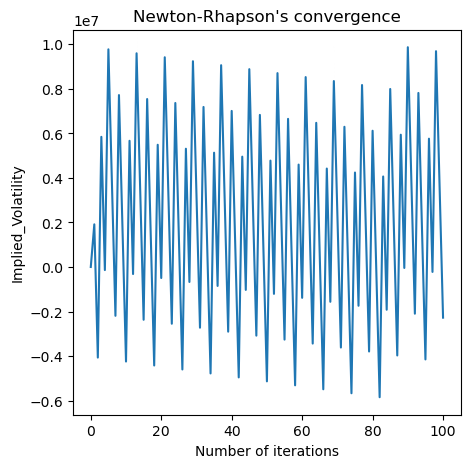

nan

In [428]:
newton_raphson_method(df.loc[0,"market_price"], df.loc[0,"strike_price"], df.loc[0,"maturity"], df.loc[0,"option_type"], 1e-4, 0.001, plot="yes")

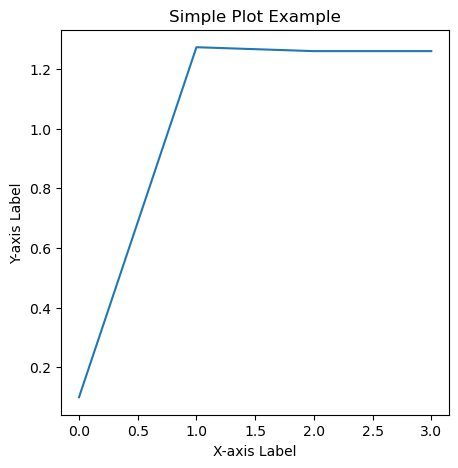

1.2595460940697045

In [423]:
newton_raphson_method(df.loc[0,"market_price"], df.loc[0,"strike_price"], df.loc[0,"maturity"], df.loc[0,"option_type"], 1e-4, 0.1, plot="yes")

In [320]:
def volatility_surface(df):

    df["imp_vol"]=[0]*len(df)
    
    for row in range(len(df)):
        df.loc[row,"imp_vol"]=implied_vol(df.loc[row,"market_price"], df.loc[row,"strike_price"], df.loc[row,"maturity"], df.loc[row,"option_type"])

    df.dropna(inplace=True)

    def implied_vol(market_price, strike_price, maturity, option_type):  
    
        init_vols=np.linspace(0.01,5,50)
    
        epsilon=1e-4

        for init_vol in init_vols:
            vol=newton_raphson_method(market_price, strike_price, maturity, option_type, epsilon, init_vol, plot="no")

            if vol is not np.nan:
                return vol 
    
        #return nan if the newton rhapsons method does not converge
        return np.nan

Lets define a function that calculates the implied volatility using the Newton Rhapson method and store in the dataframe. We will initialize volatilities btw .1 % and 500 % and use pre-defined tolerance of 10^(-4)


Now that we have calculated the volatilities, we will  

Lets define a function that calculates the implied volatility using the Newton Rhapson method and store in the dataframe. We will initialize volatilities btw .1 % and 500 % and use pre-defined tolerance of 10^(-4)

In [ ]:
def cubic_inter(k, t):
    result = griddata(points, df["imp_vol"],[[np.log(k / S), t]], method='cubic',fill_value=np.nan)
    return result[0] if isinstance(result, np.ndarray) else result
       
def linear_inter(k, t):
    result = griddata(points, df["imp_vol"],[[np.log(k / S), t]], method='linear',fill_value=np.nan)
    return result[0] if isinstance(result, np.ndarray) else result

In [229]:
def option_price_and_volatility(strike, maturity, option_type):

    sigma=return_vol(strike, maturity)

    def return_vol(strike,maturity):

        vol=cubic_inter(strike,maturity)
    
        if vol is np.nan:
            vol=linear_inter(strike,maturity)
     
        return vol
        
    return sigma,BlackScholes_price(S, strike, maturity, r, y, sigma, option_type)

25

In [231]:
df

,strike_price,maturity,market_price,option_type,imp_vol
0,80,0.25,20.15,call,1.259546
1,90,0.25,10.52,call,0.870325
2,100,0.25,3.85,call,0.605674
3,110,0.25,0.89,call,0.457246
4,120,0.25,0.11,call,0.370686
5,80,0.50,20.95,call,0.910447
6,90,0.50,12.10,call,0.669390
7,100,0.50,5.87,call,0.514315
8,110,0.50,2.15,call,0.408604
9,120,0.50,0.58,call,0.342512


In [233]:
moneyness = df["strike_price"]/S
log_moneyness = np.log(moneyness)

points = np.column_stack([log_moneyness, df["maturity"]])

In [239]:
return_vol(102,1.00)

0.43207213188750476